# Capstone

## Install/Import Modules

In [1]:
!pip install pydicom

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.0 MB 7.4 MB/s 


In [2]:
import pydicom
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Import Data

In [11]:
path = '/content/drive/MyDrive/SIADS_699_Capstone/Capstone_Team_Project' #Google Drive path
data_path = path + '/data/rsna-pneumonia' 
train_img_path = data_path + '/stage_2_train_images'
obj_path = path + '/python_objects'

In [4]:
label_df = pd.read_csv(data_path + '/stage_2_train_labels.csv')
descr_df = pd.read_csv(data_path + '/stage_2_detailed_class_info.csv')
preds_df = pd.read_csv(data_path + '/stage_2_sample_submission.csv')

In [5]:
display(label_df.head())
#display(descr_df.head())
#display(preds_df.head())

print(label_df.value_counts('Target'))


,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1


Target
0    20672
1     9555
dtype: int64


### pydicom proof of concept

0a0f91dc-6015-4342-b809-d19610854a21
(1024, 1024)
[[246 245 241 ... 231 252 153]
 [242 242 239 ... 231 251 151]
 [239 239 237 ... 230 250 150]
 ...
 [151 149 149 ... 215 243 151]
 [148 146 145 ... 215 243 150]
 [146 145 146 ... 217 244 151]]
<class 'numpy.ndarray'>
<class 'torch.Tensor'>
torch.uint8


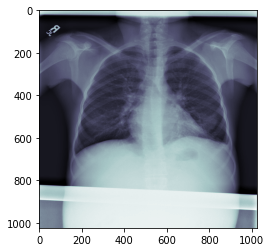

In [6]:
ds = pydicom.dcmread(train_img_path + '/0a0f91dc-6015-4342-b809-d19610854a21.dcm')
print(ds.PatientID)
print(ds.pixel_array.shape)
print(ds.pixel_array)
print(type(ds.pixel_array))
img_tensor = torch.from_numpy(ds.pixel_array)
print(type(img_tensor))
print(img_tensor.dtype)
plt.imshow(ds.pixel_array, cmap=plt.cm.bone)

## Custom Dataset Class

Definition

In [7]:
#Custom Dataset Class
class PneumoDataset():
  def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
    self.img_dir = img_dir
    self.img_labels = pd.read_csv(annotations_file)
    self.transform = transform
    self.target_transform = target_transform

  def __len__(self):
    return len(self.img_labels)

  def __getitem__(self, idx):
    filename = self.img_labels.loc[idx, 'patientId'] + '.dcm'
    img_path = os.path.join(self.img_dir, filename)
    ds = pydicom.dcmread(img_path)
    img_arr = ds.pixel_array
    img_arr = img_arr.astype(np.float32)
    img_tensor = torch.from_numpy(img_arr)
    img_tensor = img_tensor.expand(1,-1,-1)
    img_tensor.double()
    label = self.img_labels.loc[idx, 'Target']
    if self.transform:
      img_tensor = self.transform(img_tensor)
    if self.target_transform:
      label = self.target_transform(label)
    return (img_tensor, label)

  def display_img(self, idx):
    img = self.__getitem__(idx)[0]
    plt.imshow(img, cmap=plt.cm.bone)
    return None

Initialize

In [8]:
#Transforms
transform = nn.Sequential(    
            transforms.Resize((356,356)),
            transforms.Normalize((0.5), (0.5)),
    )

#Initialize Dataset
dataset = PneumoDataset(data_path + '/stage_2_train_labels.csv', train_img_path, transform=transform)

#Train / validation split
train_set, validation_set = torch.utils.data.random_split(dataset,[round(0.8*len(dataset)),round(0.2*len(dataset))])

## Dataloaders

Initialize

In [16]:
#Dataloader Hyperparameters
batch_size = 10
shuffle = True
pin_memory = True
num_workers = 1

#Initialize Dataloader
train_dataloader = DataLoader(dataset=train_set, shuffle=shuffle, batch_size=batch_size, num_workers=num_workers, pin_memory=pin_memory)
validation_dataloader = DataLoader(dataset=validation_set, shuffle=shuffle, batch_size=batch_size, num_workers=num_workers, pin_memory=pin_memory)

Benchmark batch load time

Feature batch shape: torch.Size([10, 1, 356, 356])
Labels batch shape: torch.Size([10])


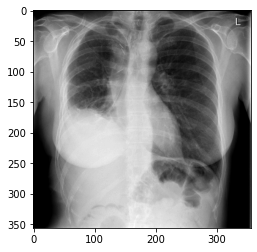

Label: 0
tensor([[  1.0000,  -1.0000,  -1.0000,  ...,  -1.0000,   9.7195,  53.4001],
        [  1.0000,  -1.0000,  -1.0000,  ...,  -1.0000,   9.9667,  53.7632],
        [  1.0000,  -1.0000,  -1.0000,  ...,   0.3820,  12.3600,  56.1947],
        ...,
        [  7.1236,  -0.8854,  -1.0000,  ...,  38.5624, 100.4391, 184.6720],
        [  7.5951,   1.0000,  -1.0000,  ...,  39.9443, 103.8210, 187.0658],
        [ 11.1236,   1.3708,  -1.0000,  ...,  40.0680, 103.8210, 186.6644]])
CPU times: user 250 ms, sys: 35.7 ms, total: 286 ms
Wall time: 7.95 s


In [21]:
%%time
# Display image and label.
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")
print(img)

Export Dataloader to file

In [18]:
torch.save(train_dataloader, obj_path + '/train_dataloader.pth')
torch.save(validation_dataloader, obj_path + '/validation_dataloader.pth')

In [19]:
train_reloaded = torch.load(obj_path + '/train_dataloader.pth')


Feature batch shape: torch.Size([10, 1, 356, 356])
Labels batch shape: torch.Size([10])


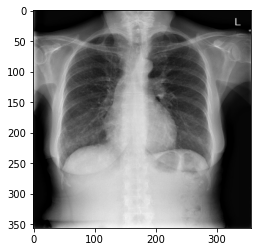

Label: 0
CPU times: user 288 ms, sys: 37 ms, total: 325 ms
Wall time: 8.61 s


In [20]:
%%time
# Display image and label.
train_features, train_labels = next(iter(train_reloaded))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")